# Predicting the Introverts from the Extroverts

Building a machine learning model using the input variables to predict the response (ie., Personality) 

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

## 1) Load Dataset

In [2]:
df = pd.read_csv("train.csv")
df.set_index("id", inplace=True) # set id as the index column
df

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
...,...,...,...,...,...,...,...,...
18519,3.0,No,7.0,3.0,No,9.0,7.0,Extrovert
18520,1.0,NaN,6.0,7.0,No,6.0,5.0,Extrovert
18521,7.0,Yes,1.0,1.0,Yes,1.0,NaN,Introvert


## 2) Check for Missing Values/ Duplicates

In [3]:
# shape of train data
df.shape

(18524, 8)

In [4]:
# info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 16631 non-null  object 
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  17375 non-null  object 
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
 7   Personality                18524 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.3+ MB


In [5]:
# finding missing values of each column
df.isnull().sum()

Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [7]:
# calc % of missing values for each column
df.isnull().sum()/df.shape[0]*100

Time_spent_Alone              6.424098
Stage_fear                   10.219175
Social_event_attendance       6.370114
Going_outside                 7.914057
Drained_after_socializing     6.202764
Friends_circle_size           5.689916
Post_frequency                6.823580
Personality                   0.000000
dtype: float64

In [8]:
# finding duplicates
df.duplicated().sum()

0

In [9]:
# identifying garbage values (always in the form of object datatype - e.g., special characters)
for i in df.select_dtypes(include="object").columns:
    print(df[i].value_counts()) # count of unique column
    print("***" *10)

No     12609
Yes     4022
Name: Stage_fear, dtype: int64
******************************
No     13313
Yes     4062
Name: Drained_after_socializing, dtype: int64
******************************
Extrovert    13699
Introvert     4825
Name: Personality, dtype: int64
******************************


Can see that there is no special character in all the categorical columns - no garbage values

 ## 3) EDA

### (i) Target Variable - Personality

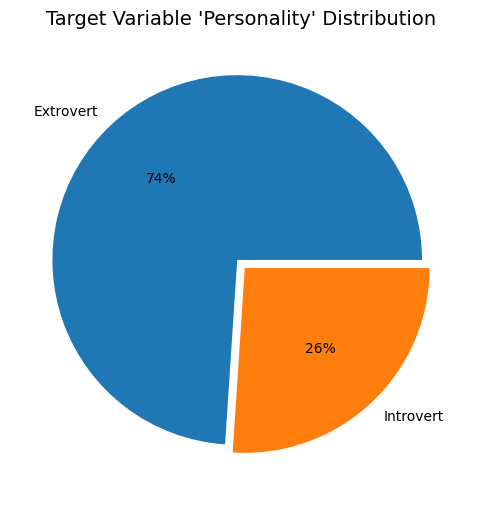

In [10]:
plt.figure(figsize = (6,6))
temp = df['Personality'].value_counts()
plt.pie(
    temp, labels = temp.index, 
    autopct = "%.0f%%",
    explode = [0.03, 0.03],
)

plt.title("Target Variable 'Personality' Distribution", fontsize=14)
plt.show()

Target variable "Personality" is imbalanced with 74% extrovert and 26% introvert. Would be good to perform resampling techiques - Oversample Introverts (e.g., SMOTE)

### Resampling to handle imbalanced data - Oversampling of Introvert Types

In [11]:
# filter out personality = introvert and append to df
df = pd.concat([df, df[df['Personality'] == "Introvert"]], axis=0)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.shape

(23349, 8)

Can observe that df dataset size increased

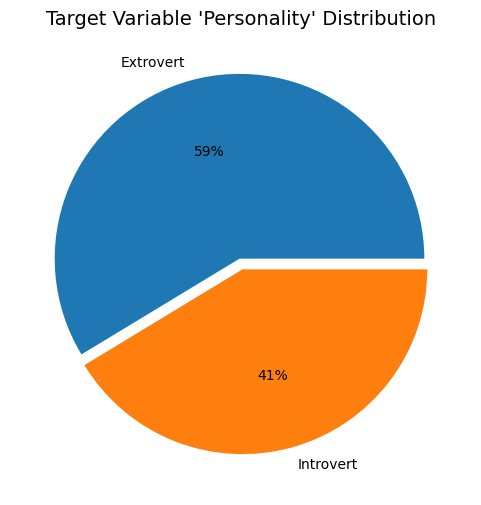

In [12]:
# check for class imbalance again
plt.figure(figsize = (6,6))
temp = df['Personality'].value_counts()
plt.pie(
    temp, labels = temp.index, 
    autopct = "%.0f%%",
    explode = [0.03, 0.03],
)

plt.title("Target Variable 'Personality' Distribution", fontsize=14)
plt.show()

Data is more balanced now after oversampling introverts; model will be more accurate for both classes.

In [13]:
# separate numerical & categorical columns
cat_cols = df.columns[:-1]
cat_cols

Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency'],
      dtype='object')

All input columns are categorical columns as all columns values are discrete integer values, not continuous values. 

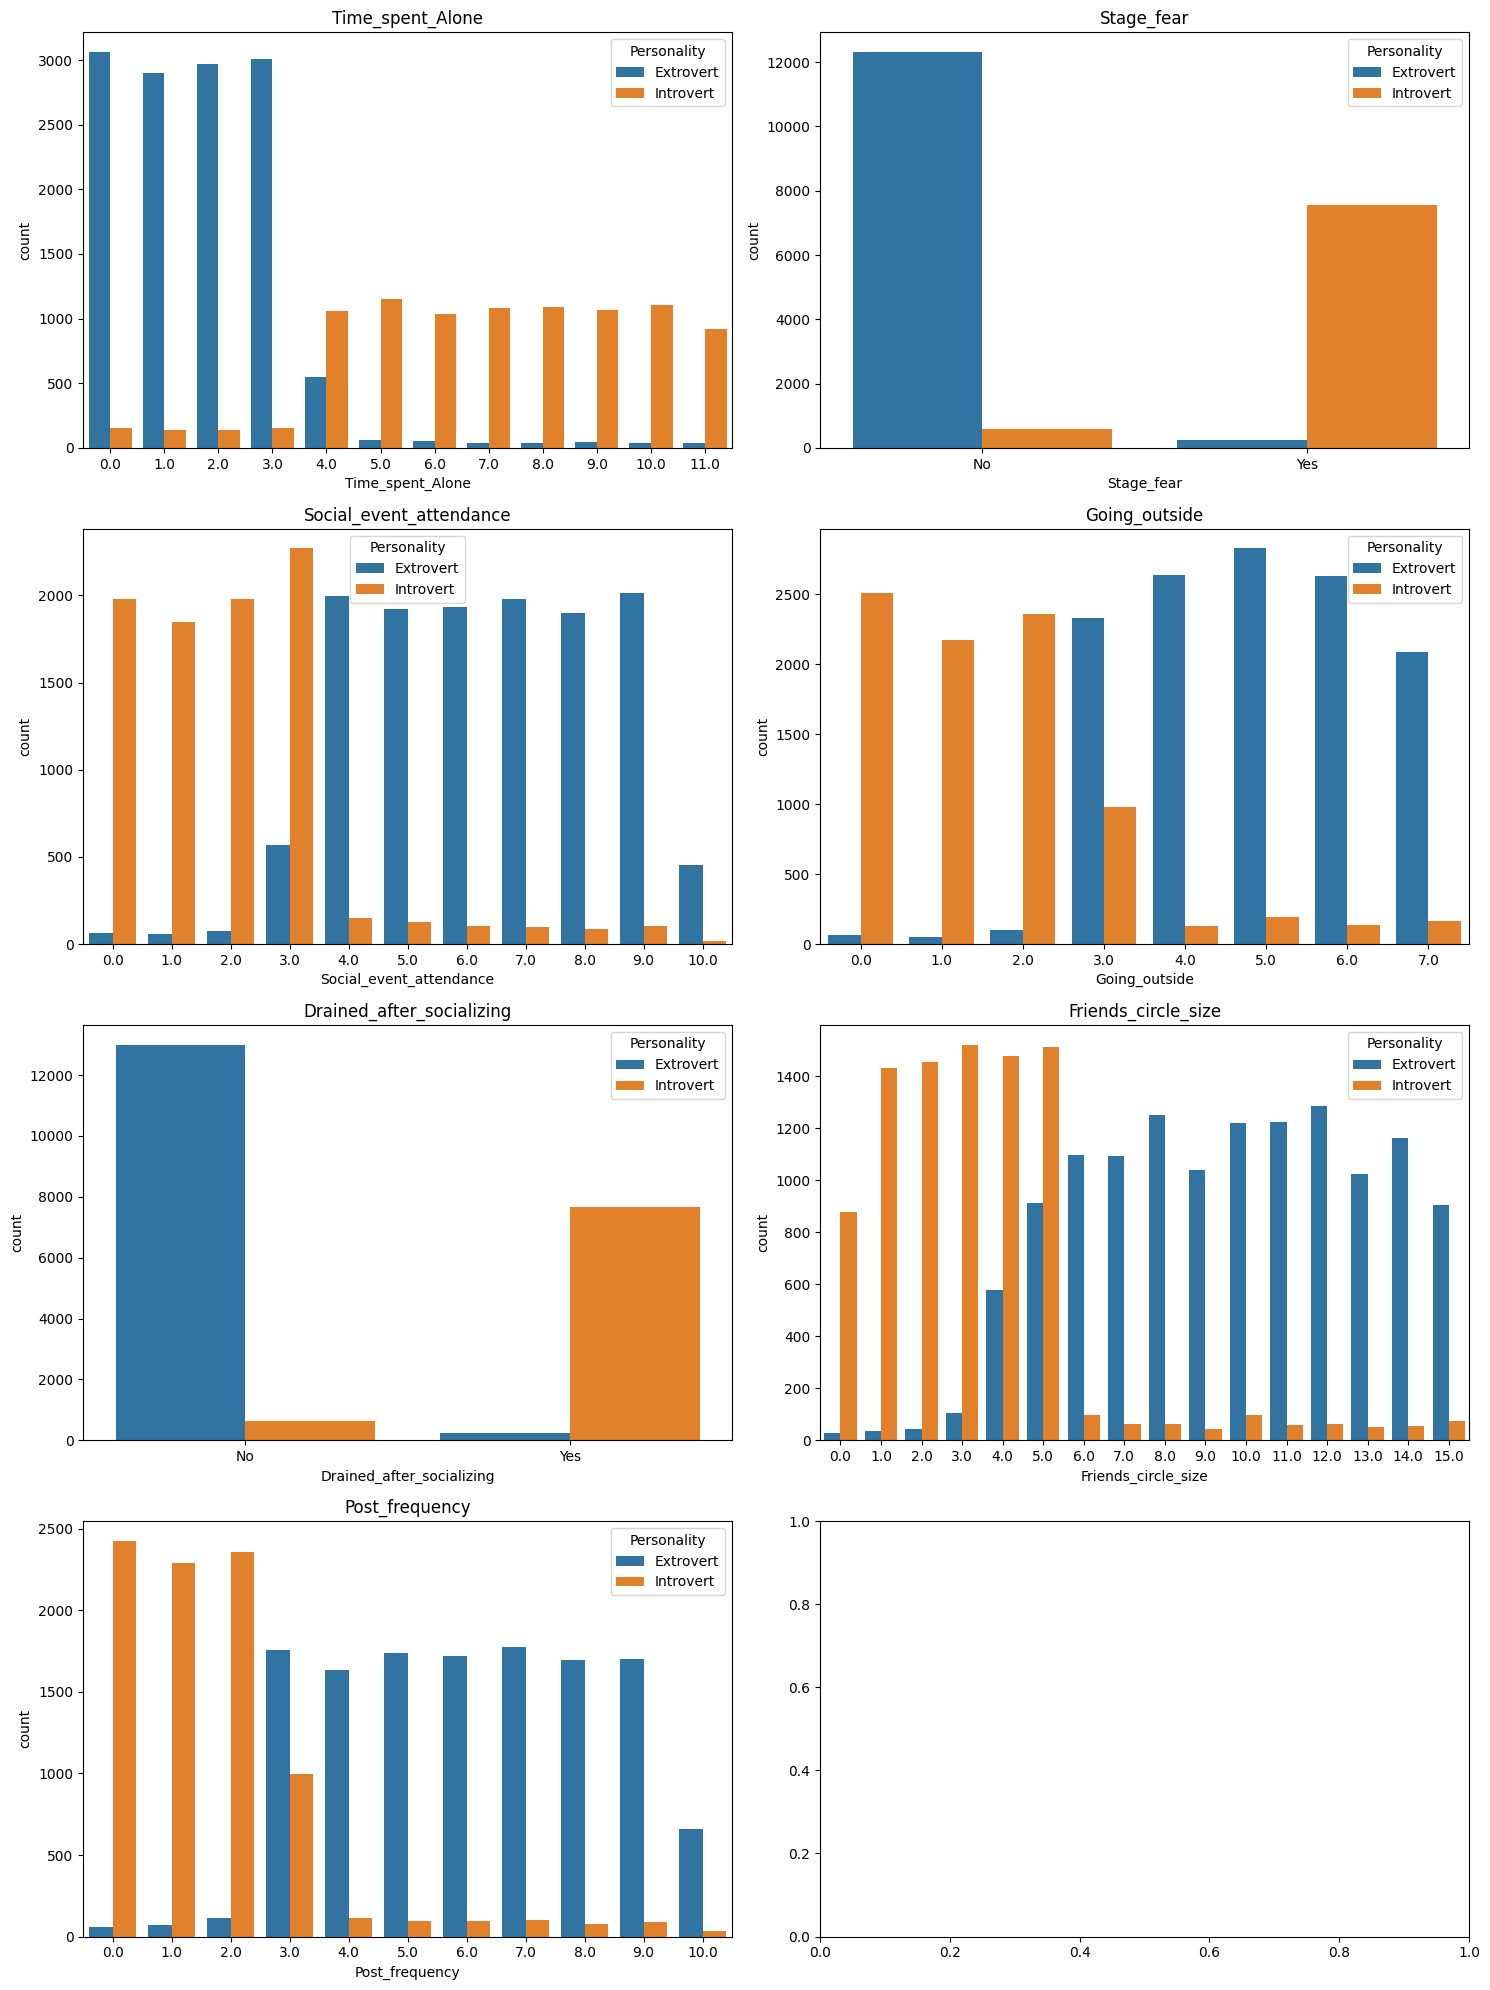

In [14]:
fig, axes = plt.subplots(nrows = 4 , ncols = 2, figsize = (15,20))

axes = axes.flatten()
for ax,col in zip(axes, cat_cols):
    sns.countplot(data=df, x=col, ax=ax, hue="Personality")
    ax.set_title(col)

plt.tight_layout()
plt.show()

Observations for introverts from visualizations above:
- Time Spent Alone: Introvert if > 4
- Stage Fear: Introvert if Yes
- Social Event Attendence: Introvert if < 4
- Going Outside: Introvert if < 3
- Drained after socializing: Introvert if Yes
- Friends Circle Size: Introvert if < 6
- Post frequency: Introvert if < 3

Useful for predicting target variable w/o machine learning

In [15]:
df['null_count'] = df.isnull().sum(axis=1)
df['null_count'].unique() 

array([0, 1, 2, 3, 4], dtype=int64)

Can see there is a maximum of 4 features being null in a particular row; can use remaining 3 features can help to predict target variable

### (ii) Using observations to handle missing values in df

In [19]:
def fill_null(df):
    for idx, row in df.iterrows():

        if row.isnull().sum() == 0: continue # skip to avoid doing the imputation unnecessarily
    
        poss = []
    
        # append 1 if condition is satifised
        if row.Time_spent_Alone > 4: poss.append(1)
        if row.Stage_fear == "Yes": poss.append(1)
        if row.Social_event_attendance < 4 : poss.append(1)
        if row.Going_outside < 3 : poss.append(1)
        if row.Drained_after_socializing == "Yes": poss.append(1)
        if row.Friends_circle_size < 6 : poss.append(1)
        if row.Post_frequency < 3 : poss.append(1)
    
        cnt = row.isnull().sum()
        
        pred = '' # prediction variable
    
        if sum(poss)>cnt//2: pred = "Introvert"
        else: pred = "Extrovert"
    
        # using observation to impute null values
    
        # boundary conditions for Extroverts
        if pred == "Extrovert":
            if pd.isnull(row.Time_spent_Alone): df.loc[idx, "Time_spent_Alone"] = 4
            if pd.isnull(row.Stage_fear): df.loc[idx, "Stage_fear"] = "No"
            if pd.isnull(row.Social_event_attendance): df.loc[idx, "Social_event_attendance"] = 4
            if pd.isnull(row.Going_outside): df.loc[idx, "Going_outside"] = 3
            if pd.isnull(row.Drained_after_socializing): df.loc[idx, "Drained_after_socializing"] = "No"
            if pd.isnull(row.Friends_circle_size): df.loc[idx, "Friends_circle_size"] = 6
            if pd.isnull(row.Post_frequency): df.loc[idx, "Post_frequency"] = 3
    
        # boundary conditions for Introverts
        else:
            if pd.isnull(row.Time_spent_Alone): df.loc[idx, "Time_spent_Alone"] = 3
            if pd.isnull(row.Stage_fear): df.loc[idx, "Stage_fear"] = "Yes"
            if pd.isnull(row.Social_event_attendance): df.loc[idx, "Social_event_attendance"] = 3
            if pd.isnull(row.Going_outside): df.loc[idx, "Going_outside"] = 2
            if pd.isnull(row.Drained_after_socializing): df.loc[idx, "Drained_after_socializing"] = "Yes"
            if pd.isnull(row.Friends_circle_size): df.loc[idx, "Friends_circle_size"] = 5
            if pd.isnull(row.Post_frequency): df.loc[idx, "Post_frequency"] = 2
            
    return df

df = fill_null(df)
df.isnull().sum()

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
null_count                   0
dtype: int64

Can observe that all the null values have been imputed by other values. 

## 3) Train-Test Dataset Split

In [20]:
# encode categorical values into numerical format
df = df.replace({"Introvert": 1, "Extrovert": 0})
df = df.replace({"Yes": 0, "No": 1})

In [21]:
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,null_count
0,1.0,1.0,4.0,6.0,1.0,7.0,5.0,0,0
1,0.0,1.0,6.0,3.0,1.0,8.0,9.0,0,0
2,3.0,1.0,4.0,5.0,1.0,13.0,8.0,0,0
3,0.0,1.0,8.0,7.0,1.0,15.0,4.0,0,0
4,2.0,1.0,4.0,4.0,1.0,4.0,4.0,0,0


In [22]:
from sklearn.model_selection import train_test_split
X = df.drop("Personality", axis = 1)
y = df["Personality"]

In [23]:
X_train, X_value, y_train, y_value = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## 4) Model Training

In [34]:
# !pip install -q catboost
# !pip install -q xgboost
# !pip install -q lightgbm

In [31]:
# import necessary libraries
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from lightgbm import LGBMClassifier

In [32]:
def plot_confusion_matrix(y_actual, y_pred, title):
    cm = confusion_matrix(y_actual, y_pred)
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

RandomForestClassifier()
Train Accuracy: 0.9967878366079554
Value Accuracy: 0.9811563169164882


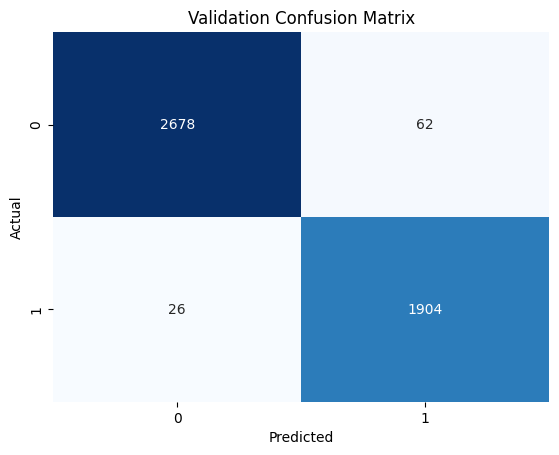


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)
Train Accuracy: 0.9703945607366561
Value Accuracy: 0.9659528907922912


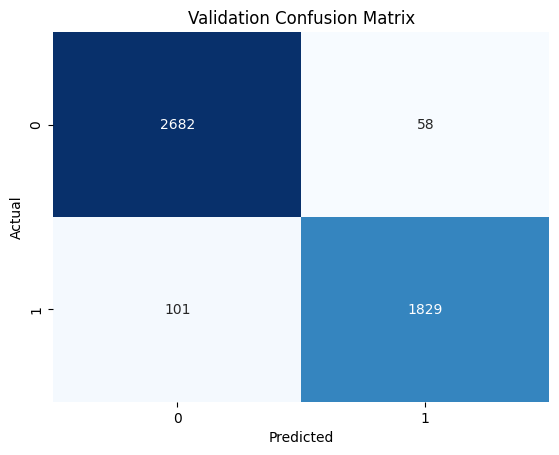


Train Accuracy: 0.9679854381926227
Value Accuracy: 0.9668094218415417


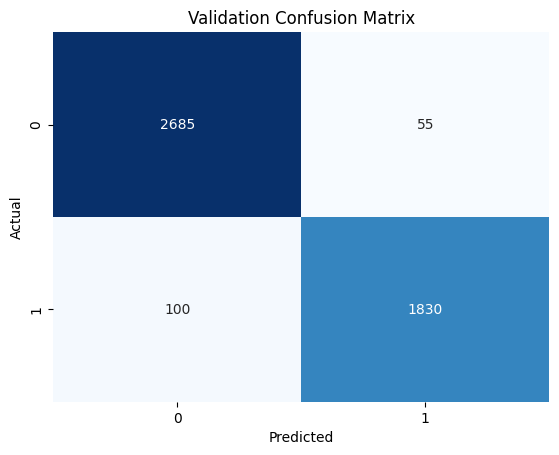


LogisticRegression()
Train Accuracy: 0.9605974623909203
Value Accuracy: 0.9655246252676659


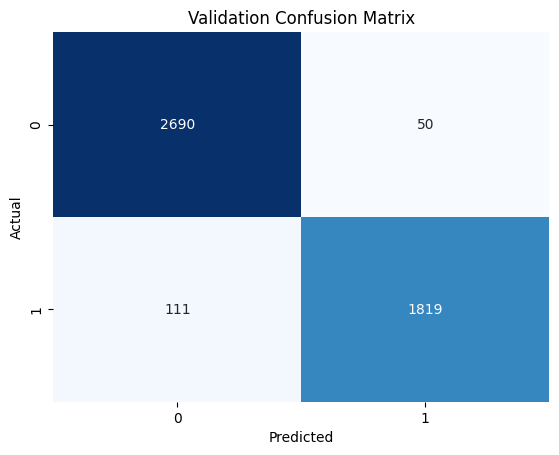


[LightGBM] [Info] Number of positive: 7720, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67
[LightGBM] [Info] Number of data points in the train set: 18679, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.413298 -> initscore=-0.350347
[LightGBM] [Info] Start training from score -0.350347
LGBMClassifier(metric='binary_error', objective='binary')
Train Accuracy: 0.9647197387440442
Value Accuracy: 0.9670235546038544


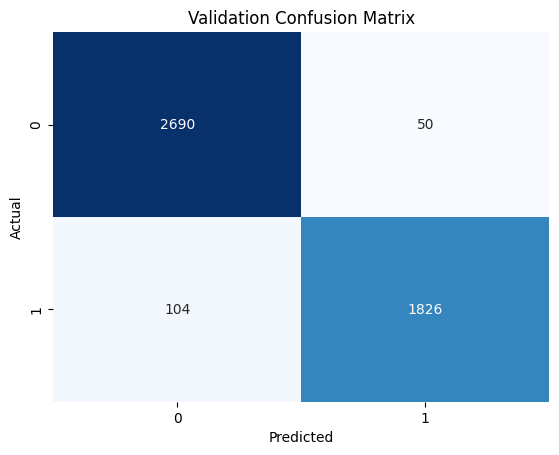

In [33]:
models = [RandomForestClassifier(), 
          XGBClassifier(),
          CatBoostClassifier(verbose = False), 
          LogisticRegression(),
          LGBMClassifier(objective="binary", metric = "binary_error", )
         ]

for i in range(len(models)):

    models[i].fit(X_train, y_train)
    y_train_pred = models[i].predict(X_train)
    y_value_pred = models[i].predict(X_value)

    print(models[i])
    print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Value Accuracy:", accuracy_score(y_value, y_value_pred))
    plot_confusion_matrix(y_value, y_value_pred, "Validation Confusion Matrix")
    
    print()

After comparing the training and test accuracies of various models, the Random Forest Classifier performs best, achieving a training accuracy of 0.997 and a test accuracy of 0.981. Thus, we will be using the Random Forest Classifier to predict the target variable "Personality" for the test set.

## 5) Inference for Test Dataset

In [36]:
test = pd.read_csv("test.csv")
test.set_index("id", inplace=True) # set id as the index column
test

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
id,,,,,,,
18524,3.0,No,7.0,4.0,No,6.0,NaN
18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
18526,3.0,No,5.0,6.0,No,15.0,9.0
18527,3.0,No,4.0,4.0,No,5.0,6.0
18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0
...,...,...,...,...,...,...,...
24694,3.0,No,5.0,5.0,No,9.0,6.0
24695,8.0,Yes,2.0,1.0,Yes,0.0,0.0
24696,2.0,No,4.0,3.0,No,9.0,7.0


### (i) Cleaning and Preprocessing of Test Dataset (i.e., replacing missing values)

In [42]:
test['null_count'] = test.isnull().sum(axis=1)
test = fill_null(test) # replace missing values
test = test.replace({"Yes": 0, "No": 1}) # encode categorical values to numerical format
test.isnull().sum()

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
null_count                   0
dtype: int64

In [43]:
test

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,null_count
id,,,,,,,,
18524,3.0,1,7.0,4.0,1,6.0,3.0,0
18525,3.0,0,0.0,0.0,0,5.0,1.0,0
18526,3.0,1,5.0,6.0,1,15.0,9.0,0
18527,3.0,1,4.0,4.0,1,5.0,6.0,0
18528,9.0,0,1.0,2.0,0,1.0,1.0,0
...,...,...,...,...,...,...,...,...
24694,3.0,1,5.0,5.0,1,9.0,6.0,0
24695,8.0,0,2.0,1.0,0,0.0,0.0,0
24696,2.0,1,4.0,3.0,1,9.0,7.0,0


### (ii) Using the Random Forest Classifier Model to predict Personality in Test Set 

In [48]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission['Personality'] = models[0].predict(test) # predict using Random Forest on test set
sample_submission.replace({1: "Introvert", 0: "Extrovert"}, inplace = True)

In [49]:
sample_submission

,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert
...,...,...
6170,24694,Extrovert
6171,24695,Introvert
6172,24696,Extrovert
6173,24697,Extrovert


In [55]:
sample_submission.to_csv("submission.csv", index=False)

## Alternative Method: Prediction Without ML

In [2]:
test = pd.read_csv("test.csv")
test.set_index("id", inplace=True) # set id as the index column
test

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
id,,,,,,,
18524,3.0,No,7.0,4.0,No,6.0,NaN
18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
18526,3.0,No,5.0,6.0,No,15.0,9.0
18527,3.0,No,4.0,4.0,No,5.0,6.0
18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0
...,...,...,...,...,...,...,...
24694,3.0,No,5.0,5.0,No,9.0,6.0
24695,8.0,Yes,2.0,1.0,Yes,0.0,0.0
24696,2.0,No,4.0,3.0,No,9.0,7.0


In [4]:
preds = []

for idx, row in test.iterrows():
    
    poss = []

    # introvert condition
    if row.Time_spent_Alone > 4: poss.append(1)
    if row.Stage_fear == "Yes": poss.append(1)
    if row.Social_event_attendance < 4 : poss.append(1)
    if row.Going_outside < 3 : poss.append(1)
    if row.Drained_after_socializing == "Yes": poss.append(1)
    if row.Friends_circle_size < 6 : poss.append(1)
    if row.Post_frequency < 3 : poss.append(1)

    cnt = row.isnull().sum()
    if sum(poss)>cnt//2: preds.append("Introvert")
    else: preds.append("Extrovert")

In [8]:
len(preds)

6175

In [14]:
sample_submission_without_ML = pd.read_csv("sample_submission.csv")
sample_submission_without_ML['Personality'] = preds # predict using simply the observations abv without using  ML
sample_submission_without_ML.to_csv("submission_without_ml.csv", index=False)
sample_submission_without_ML

,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Introvert
4,18528,Introvert
...,...,...
6170,24694,Extrovert
6171,24695,Introvert
6172,24696,Extrovert
6173,24697,Extrovert
